# Macro Announcement Effects Analysis - Free Data Sources

This notebook demonstrates how to collect and analyze financial and economic data using **completely free** data sources without requiring any paid API keys. The analysis focuses on studying the effects of macroeconomic announcements on cryptocurrency vs U.S. stock market returns.

## Key Features:
- ✅ **No paid APIs required** - All data sources are free
- ✅ **Yahoo Finance** - Free stock market data via `yfinance`
- ✅ **CoinGecko** - Free cryptocurrency data (no API key needed)
- ✅ **FRED** - Free economic data via `pandas-datareader`
- ✅ **Reproducible research** - Complete methodology implementation

## Research Questions:
1. How do macroeconomic announcements affect cryptocurrency returns and volatility?
2. How do these effects compare to traditional stock market responses?
3. Are there asymmetric effects based on surprise direction or market regime?
4. What is the timing and persistence of these responses?

## 1. Environment Setup and Configuration

First, let's set up our environment and import all necessary libraries. We'll use only free, open-source packages.

In [1]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import sys
from pathlib import Path
import os

# Import data collection libraries (all free!)
import yfinance as yf  # Yahoo Finance - completely free
import requests  # For CoinGecko API calls
try:
    import pandas_datareader.data as web  # FRED data access
    FRED_AVAILABLE = True
except ImportError:
    FRED_AVAILABLE = False
    print("pandas_datareader not installed. Will use alternative methods for FRED data.")

# Statistical analysis libraries
import scipy.stats as stats
from scipy import signal

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
np.random.seed(42)

print("✅ All libraries imported successfully!")
print("✅ Using completely FREE data sources:")
print("   - Yahoo Finance (yfinance)")
print("   - CoinGecko Public API")
print("   - FRED (via pandas-datareader)" if FRED_AVAILABLE else "   - FRED (via direct downloads)")
print("\n🎯 No API keys required for basic functionality!")

✅ All libraries imported successfully!
✅ Using completely FREE data sources:
   - Yahoo Finance (yfinance)
   - CoinGecko Public API
   - FRED (via pandas-datareader)

🎯 No API keys required for basic functionality!


In [2]:
# Setup project paths and configuration
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
data_dir = project_root / "data"
data_dir.mkdir(exist_ok=True)

# Create subdirectories
(data_dir / "raw").mkdir(exist_ok=True)
(data_dir / "processed").mkdir(exist_ok=True)

# Configuration for data collection
config = {
    'data_sources': {
        'yahoo_finance': {
            'symbols': {
                'stocks': ['^GSPC', '^VIX', '^TNX', '^DJI'],  # S&P 500, VIX, 10Y Treasury, Dow Jones
                'crypto_yahoo': ['BTC-USD', 'ETH-USD']  # Crypto symbols on Yahoo Finance
            }
        },
        'coingecko': {
            'base_url': 'https://api.coingecko.com/api/v3',
            'symbols': ['bitcoin', 'ethereum'],
            'rate_limit': 1.2  # seconds between requests for free tier
        },
        'fred': {
            'indicators': [
                'UNRATE',    # Unemployment Rate
                'CPIAUCSL',  # Consumer Price Index
                'GDP',       # Gross Domestic Product
                'FEDFUNDS',  # Federal Funds Rate
                'DGS10',     # 10-Year Treasury Rate
                'VIXCLS',    # VIX Close
                'DEXUSEU'    # USD/EUR Exchange Rate
            ]
        }
    },
    'analysis': {
        'start_date': '2020-01-01',
        'end_date': datetime.now().strftime('%Y-%m-%d'),
        'event_window_days': 3,
        'estimation_window_days': 250
    }
}

print(f"📁 Project root: {project_root}")
print(f"📁 Data directory: {data_dir}")
print(f"📅 Analysis period: {config['analysis']['start_date']} to {config['analysis']['end_date']}")
print("⚙️  Configuration loaded successfully!")

📁 Project root: d:\Works\Researchs\macro-announcement-effect
📁 Data directory: d:\Works\Researchs\macro-announcement-effect\data
📅 Analysis period: 2020-01-01 to 2025-09-23
⚙️  Configuration loaded successfully!


## 2. Load Free Data Sources

Now let's define our data collection functions for each free data source. All functions are designed to work without API keys.

In [3]:
def collect_yahoo_finance_data(symbols, start_date, end_date, data_type='Close'):
    """
    Collect data from Yahoo Finance using yfinance (completely free).
    
    Parameters:
    - symbols: list of symbols to collect
    - start_date: start date for data collection
    - end_date: end date for data collection
    - data_type: type of data to collect ('Close', 'Open', 'High', 'Low', 'Volume')
    """
    print(f"🔄 Collecting Yahoo Finance data for {len(symbols)} symbols...")
    
    all_data = pd.DataFrame()
    
    for symbol in symbols:
        try:
            print(f"   📈 Fetching {symbol}...")
            
            # Create ticker object
            ticker = yf.Ticker(symbol)
            
            # Download historical data
            hist_data = ticker.history(start=start_date, end=end_date, auto_adjust=True)
            
            if not hist_data.empty:
                all_data[symbol] = hist_data[data_type]
                print(f"   ✅ {symbol}: {len(hist_data)} observations")
            else:
                print(f"   ⚠️  {symbol}: No data found")
                
        except Exception as e:
            print(f"   ❌ {symbol}: Error - {str(e)[:50]}...")
            continue
    
    if not all_data.empty:
        all_data.index.name = 'Date'
        print(f"✅ Yahoo Finance data collection completed: {all_data.shape}")
        return all_data
    else:
        print("❌ No data collected from Yahoo Finance")
        return pd.DataFrame()

def collect_coingecko_data(coin_ids, start_date, end_date, vs_currency='usd'):
    """
    Collect cryptocurrency data from CoinGecko public API (no key required).
    
    Parameters:
    - coin_ids: list of CoinGecko coin IDs (e.g., ['bitcoin', 'ethereum'])
    - start_date: start date for data collection
    - end_date: end date for data collection
    - vs_currency: currency to get prices in
    """
    import time
    
    print(f"🔄 Collecting CoinGecko data for {len(coin_ids)} cryptocurrencies...")
    
    base_url = "https://api.coingecko.com/api/v3"
    all_data = pd.DataFrame()
    
    # Convert dates to timestamps
    start_timestamp = int(pd.to_datetime(start_date).timestamp())
    end_timestamp = int(pd.to_datetime(end_date).timestamp())
    
    for coin_id in coin_ids:
        try:
            print(f"   🪙 Fetching {coin_id}...")
            
            # CoinGecko market chart endpoint
            url = f"{base_url}/coins/{coin_id}/market_chart/range"
            params = {
                'vs_currency': vs_currency,
                'from': start_timestamp,
                'to': end_timestamp
            }
            
            response = requests.get(url, params=params)
            response.raise_for_status()
            
            data = response.json()
            
            if 'prices' in data and data['prices']:
                # Convert to DataFrame
                prices_df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
                prices_df['date'] = pd.to_datetime(prices_df['timestamp'], unit='ms')
                prices_df.set_index('date', inplace=True)
                
                all_data[coin_id] = prices_df['price']
                print(f"   ✅ {coin_id}: {len(prices_df)} observations")
            else:
                print(f"   ⚠️  {coin_id}: No price data found")
            
            # Rate limiting for free tier
            time.sleep(1.2)
            
        except Exception as e:
            print(f"   ❌ {coin_id}: Error - {str(e)[:50]}...")
            continue
    
    if not all_data.empty:
        all_data.index.name = 'Date'
        print(f"✅ CoinGecko data collection completed: {all_data.shape}")
        return all_data
    else:
        print("❌ No data collected from CoinGecko")
        return pd.DataFrame()

def collect_fred_data(indicators, start_date, end_date):
    """
    Collect economic data from FRED (Federal Reserve Economic Data).
    Uses pandas_datareader which provides free access to FRED data.
    
    Parameters:
    - indicators: list of FRED series IDs
    - start_date: start date for data collection
    - end_date: end date for data collection
    """
    print(f"🔄 Collecting FRED economic data for {len(indicators)} indicators...")
    
    all_data = pd.DataFrame()
    
    if not FRED_AVAILABLE:
        print("⚠️  pandas_datareader not available. Using sample data.")
        # Create sample economic indicators for demonstration
        date_range = pd.date_range(start=start_date, end=end_date, freq='M')
        np.random.seed(42)
        
        sample_data = {
            'UNRATE': 3.5 + np.random.normal(0, 0.5, len(date_range)),  # Unemployment rate
            'CPIAUCSL': 250 + np.cumsum(np.random.normal(0.1, 0.3, len(date_range))),  # CPI
            'FEDFUNDS': 2.0 + np.random.normal(0, 0.5, len(date_range)),  # Fed funds rate
            'DGS10': 2.5 + np.random.normal(0, 0.3, len(date_range)),  # 10Y Treasury
        }
        
        for indicator in indicators[:4]:  # Use first 4 indicators
            if indicator in sample_data:
                all_data[indicator] = pd.Series(sample_data[indicator], index=date_range)
                print(f"   📊 {indicator}: {len(date_range)} sample observations")
        
        print("✅ Sample FRED data created for demonstration")
        return all_data
    
    for indicator in indicators:
        try:
            print(f"   📊 Fetching {indicator}...")
            
            # Use pandas_datareader to get FRED data
            series_data = web.DataReader(indicator, 'fred', start_date, end_date)
            
            if not series_data.empty:
                all_data[indicator] = series_data.iloc[:, 0]  # First column
                print(f"   ✅ {indicator}: {len(series_data)} observations")
            else:
                print(f"   ⚠️  {indicator}: No data found")
                
        except Exception as e:
            print(f"   ❌ {indicator}: Error - {str(e)[:50]}...")
            continue
    
    if not all_data.empty:
        all_data.index.name = 'Date'
        print(f"✅ FRED data collection completed: {all_data.shape}")
        return all_data
    else:
        print("❌ No data collected from FRED")
        return pd.DataFrame()

print("✅ Data collection functions defined!")
print("🎯 All functions use FREE data sources without API keys!")

✅ Data collection functions defined!
🎯 All functions use FREE data sources without API keys!


## 3. Collect Stock Market Data (Yahoo Finance)

In [4]:
# Define stock market symbols (major U.S. indices and individual stocks)
stock_symbols = [
    '^GSPC',  # S&P 500
    '^DJI',   # Dow Jones
    '^IXIC',  # NASDAQ
    'SPY',    # S&P 500 ETF
    'QQQ',    # NASDAQ ETF
    'AAPL',   # Apple
    'MSFT',   # Microsoft
    'GOOGL',  # Google
    'AMZN',   # Amazon
    'TSLA',   # Tesla
    'JPM',    # JPMorgan Chase
    'BAC',    # Bank of America
    'XLF',    # Financial Select Sector SPDR Fund
]

# Set date range for analysis
start_date = '2020-01-01'
end_date = '2024-01-01'

print("🚀 Starting stock market data collection...")
print(f"📅 Date range: {start_date} to {end_date}")
print(f"📈 Symbols: {len(stock_symbols)} instruments")

# Collect stock data
stock_data = collect_yahoo_finance_data(stock_symbols, start_date, end_date)

# Display summary
if not stock_data.empty:
    print(f"\n📊 Stock Data Summary:")
    print(f"   📅 Date range: {stock_data.index[0].strftime('%Y-%m-%d')} to {stock_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"   📈 Instruments: {stock_data.shape[1]}")
    print(f"   📋 Observations: {stock_data.shape[0]}")
    print(f"   🔍 Data completeness: {(stock_data.notna().sum() / len(stock_data) * 100).round(1).mean():.1f}%")
    
    # Show first few rows
    print(f"\n🔍 First 5 rows:")
    display(stock_data.head())
    
    # Basic statistics
    print(f"\n📈 Price levels (latest):")
    display(stock_data.iloc[-1].round(2))
else:
    print("❌ No stock data collected. Check symbols and date range.")

🚀 Starting stock market data collection...
📅 Date range: 2020-01-01 to 2024-01-01
📈 Symbols: 13 instruments
🔄 Collecting Yahoo Finance data for 13 symbols...
   📈 Fetching ^GSPC...
   ✅ ^GSPC: 1006 observations
   📈 Fetching ^DJI...
   ✅ ^DJI: 1006 observations
   📈 Fetching ^IXIC...
   ✅ ^IXIC: 1006 observations
   📈 Fetching SPY...
   ✅ SPY: 1006 observations
   📈 Fetching QQQ...
   ✅ QQQ: 1006 observations
   📈 Fetching AAPL...
   ✅ AAPL: 1006 observations
   📈 Fetching MSFT...
   ✅ MSFT: 1006 observations
   📈 Fetching GOOGL...
   ✅ GOOGL: 1006 observations
   📈 Fetching AMZN...
   ✅ AMZN: 1006 observations
   📈 Fetching TSLA...
   ✅ TSLA: 1006 observations
   📈 Fetching JPM...
   ✅ JPM: 1006 observations
   📈 Fetching BAC...
   ✅ BAC: 1006 observations
   📈 Fetching XLF...
   ✅ XLF: 1006 observations
✅ Yahoo Finance data collection completed: (1006, 13)

📊 Stock Data Summary:
   📅 Date range: 2020-01-02 to 2023-12-29
   📈 Instruments: 13
   📋 Observations: 1006
   🔍 Data completen

,^GSPC,^DJI,^IXIC,SPY,QQQ,AAPL,MSFT,GOOGL,AMZN,TSLA,JPM,BAC,XLF
Date,,,,,,,,,,,,,
2020-01-02 00:00:00-05:00,3257.850098,28868.800781,9092.190430,298.578674,208.848953,72.538490,152.791153,67.965233,94.900497,28.684000,120.154701,30.920334,27.882177
2020-01-03 00:00:00-05:00,3234.850098,28634.880859,9020.769531,296.317719,206.935898,71.833298,150.888580,67.609680,93.748497,29.534000,118.569099,30.278324,27.586134
2020-01-06 00:00:00-05:00,3246.280029,28703.380859,9071.469727,297.448181,208.269241,72.405685,151.278595,69.411758,95.143997,30.102667,118.474808,30.234949,27.568188
2020-01-07 00:00:00-05:00,3237.179932,28583.679688,9068.580078,296.611847,208.240265,72.065140,149.899292,69.277687,95.343002,31.270666,116.460655,30.035397,27.388765
2020-01-08 00:00:00-05:00,3253.050049,28745.089844,9129.240234,298.192688,209.805466,73.224403,152.286926,69.770782,94.598503,32.809334,117.369186,30.339058,27.568188



📈 Price levels (latest):


^GSPC     4769.83
^DJI     37689.54
^IXIC    15011.35
SPY        465.21
QQQ        405.57
AAPL       190.91
MSFT       371.21
GOOGL      138.73
AMZN       151.94
TSLA       248.48
JPM        163.48
BAC         32.26
XLF         36.64
Name: 2023-12-29 00:00:00-05:00, dtype: float64

## 4. Collect Cryptocurrency Data (CoinGecko)

In [ ]:
import yfinance as yf
import pandas as pd
import sys
from pathlib import Path

# Add project root to path to access config
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

# Load configuration to get crypto symbols
try:
    from src.utils.config import Config
    config_obj = Config()
    crypto_symbols_list = config_obj.get('data_sources.crypto.symbols', [])
    print(f"✅ Loaded {len(crypto_symbols_list)} crypto symbols from config")
except Exception as e:
    print(f"⚠️ Could not load config, using default cryptos: {e}")
    crypto_symbols_list = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD',
                           'SOL-USD', 'DOGE-USD', 'MATIC-USD', 'DOT-USD', 'AVAX-USD']

# Create mapping from Yahoo Finance ticker to clean name
crypto_symbols = {}
for symbol in crypto_symbols_list:
    # Extract clean name from symbol (remove -USD suffix)
    clean_name = symbol.replace('-USD', '').lower()
    # Map common names
    name_mapping = {
        'btc': 'bitcoin',
        'eth': 'ethereum',
        'bnb': 'binancecoin',
        'ada': 'cardano',
        'sol': 'solana',
        'doge': 'dogecoin',
        'matic': 'polygon',
        'dot': 'polkadot',
        'avax': 'avalanche',
        'xrp': 'ripple'
    }
    display_name = name_mapping.get(clean_name, clean_name)
    crypto_symbols[display_name] = symbol

start_date = "2020-01-01"
end_date = "2025-09-23"

print("🚀 Starting cryptocurrency data collection...")
print(f"📅 Date range: {start_date} to {end_date}")
print(f"🪙 Cryptocurrencies: {len(crypto_symbols)} coins")
print(f"💱 Currency: USD")
print(f"📋 Symbols: {list(crypto_symbols.keys())}")

def collect_yfinance_data(symbols, start, end):
    df = pd.DataFrame()
    for name, ticker in symbols.items():
        try:
            print(f"   🔄 Fetching {name} ({ticker})...")
            data = yf.download(ticker, start=start, end=end, progress=False)[['Close']]
            data = data.rename(columns={'Close': name})
            if df.empty:
                df = data
            else:
                df = df.join(data, how='outer')
            print(f"   ✅ {name}: {len(data)} observations")
        except Exception as e:
            print(f"   ⚠️ Error fetching {name}: {e}")
    return df

# Collect cryptocurrency data
crypto_data = collect_yfinance_data(crypto_symbols, start_date, end_date)

# Display summary
if not crypto_data.empty:
    print(f"\n📊 Crypto Data Summary:")
    print(f"   📅 Date range: {crypto_data.index[0].strftime('%Y-%m-%d')} to {crypto_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"   🪙 Cryptocurrencies: {crypto_data.shape[1]}")
    print(f"   📋 Observations: {crypto_data.shape[0]}")
    print(f"   🔍 Data completeness: {(crypto_data.notna().sum() / len(crypto_data) * 100).round(1).mean():.1f}%")

    print(f"\n🔍 First 5 rows:")
    print(crypto_data.head())

    print(f"\n💰 Price levels (latest USD):")
    print(crypto_data.iloc[-1].round(2))
else:
    print("❌ No cryptocurrency data collected. Check symbols and date range.")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

🚀 Starting cryptocurrency data collection...
📅 Date range: 2020-01-01 to 2025-09-23
🪙 Cryptocurrencies: 10 coins
💱 Currency: USD



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📊 Crypto Data Summary:
   📅 Date range: 2020-01-01 to 2025-09-22
   🪙 Cryptocurrencies: 10
   📋 Observations: 2092
   🔍 Data completeness: 97.9%

🔍 First 5 rows:
Price           bitcoin    ethereum binancecoin   cardano  solana  dogecoin  \
Ticker          BTC-USD     ETH-USD     BNB-USD   ADA-USD SOL-USD  DOGE-USD   
Date                                                                          
2020-01-01  7200.174316  130.802002   13.689083  0.033458     NaN  0.002033   
2020-01-02  6985.470215  127.410179   13.027011  0.032751     NaN  0.002009   
2020-01-03  7344.884277  134.171707   13.660452  0.034180     NaN  0.002145   
2020-01-04  7410.656738  135.069366   13.891512  0.034595     NaN  0.002241   
2020-01-05  7411.317383  136.276779   14.111019  0.034721     NaN  0.002419   

Price        polygon chainlink   uniswap   litecoin  
Ticker     MATIC-USD  LINK-USD   UNI-USD    LTC-USD  
Date                                                 
2020-01-01  0.014962  1.806640  0.002586  

## 5. Collect Economic Data (FRED)

In [6]:
# Define economic indicators from FRED (Federal Reserve Economic Data)
economic_indicators = [
    'UNRATE',     # Unemployment Rate
    'CPIAUCSL',   # Consumer Price Index for All Urban Consumers
    'FEDFUNDS',   # Federal Funds Rate
    'DGS10',      # 10-Year Treasury Constant Maturity Rate
    'DGS2',       # 2-Year Treasury Constant Maturity Rate
    'GDPC1',      # Real Gross Domestic Product
    'PAYEMS',     # All Employees, Total Nonfarm Payrolls
    'HOUST',      # Housing Starts
    'INDPRO',     # Industrial Production Index
    'RETAILSMSA', # Advance Retail Sales
]

print("🚀 Starting economic data collection...")
print(f"📅 Date range: {start_date} to {end_date}")
print(f"📊 Economic indicators: {len(economic_indicators)} series")
print(f"🏛️ Source: Federal Reserve Economic Data (FRED)")

# Collect economic data
econ_data = collect_fred_data(economic_indicators, start_date, end_date)

# Display summary
if not econ_data.empty:
    print(f"\n📊 Economic Data Summary:")
    print(f"   📅 Date range: {econ_data.index[0].strftime('%Y-%m-%d')} to {econ_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"   📈 Indicators: {econ_data.shape[1]}")
    print(f"   📋 Observations: {econ_data.shape[0]}")
    print(f"   🔍 Data completeness: {(econ_data.notna().sum() / len(econ_data) * 100).round(1).mean():.1f}%")
    
    # Show first few rows
    print(f"\n🔍 First 5 rows:")
    display(econ_data.head())
    
    # Basic statistics
    print(f"\n📊 Latest economic indicators:")
    latest_data = econ_data.dropna().iloc[-1]
    for indicator, value in latest_data.items():
        print(f"   {indicator}: {value:.2f}")
else:
    print("❌ No economic data collected. Check indicators and date range.")

🚀 Starting economic data collection...
📅 Date range: 2020-01-01 to 2025-09-23
📊 Economic indicators: 10 series
🏛️ Source: Federal Reserve Economic Data (FRED)
🔄 Collecting FRED economic data for 10 indicators...
   📊 Fetching UNRATE...
   ✅ UNRATE: 68 observations
   📊 Fetching CPIAUCSL...
   ✅ CPIAUCSL: 68 observations
   📊 Fetching FEDFUNDS...
   ✅ FEDFUNDS: 68 observations
   📊 Fetching DGS10...
   ✅ DGS10: 1493 observations
   📊 Fetching DGS2...
   ✅ DGS2: 1493 observations
   📊 Fetching GDPC1...
   ✅ GDPC1: 22 observations
   📊 Fetching PAYEMS...
   ✅ PAYEMS: 68 observations
   📊 Fetching HOUST...
   ✅ HOUST: 68 observations
   📊 Fetching INDPRO...
   ✅ INDPRO: 68 observations
   📊 Fetching RETAILSMSA...
   ✅ RETAILSMSA: 67 observations
✅ FRED data collection completed: (68, 10)

📊 Economic Data Summary:
   📅 Date range: 2020-01-01 to 2025-08-01
   📈 Indicators: 10
   📋 Observations: 68
   🔍 Data completeness: 86.3%

🔍 First 5 rows:


,UNRATE,CPIAUCSL,FEDFUNDS,DGS10,DGS2,GDPC1,PAYEMS,HOUST,INDPRO,RETAILSMSA
Date,,,,,,,,,,
2020-01-01,3.6,259.127,1.55,NaN,NaN,20693.238,152031,1581,101.3372,447774.0
2020-02-01,3.5,259.250,1.58,NaN,NaN,NaN,152292,1549,101.6718,447972.0
2020-03-01,4.4,258.076,0.65,NaN,NaN,NaN,150895,1266,97.6060,420954.0
2020-04-01,14.8,256.032,0.05,0.62,0.23,19056.617,130424,936,84.6812,370296.0
2020-05-01,13.2,255.802,0.05,0.64,0.20,NaN,133040,1039,86.0108,437957.0



📊 Latest economic indicators:
   UNRATE: 4.20
   CPIAUCSL: 320.32
   FEDFUNDS: 4.33
   DGS10: 4.17
   DGS2: 3.87
   GDPC1: 23703.78
   PAYEMS: 159433.00
   HOUST: 1398.00
   INDPRO: 103.62
   RETAILSMSA: 623521.00


## 6. Data Validation and Preprocessing

In [9]:
import pandas as pd
import numpy as np

def validate_and_clean_data(data, name):
    """Validate and clean the collected data."""
    print(f"\n🔍 Validating {name} data...")

    # Check empty
    if data is None or data.empty:
        print(f"   ❌ {name}: No data available")
        return pd.DataFrame()

    # Ensure datetime index
    if not isinstance(data.index, pd.DatetimeIndex):
        try:
            data.index = pd.to_datetime(data.index)
        except Exception as e:
            print(f"   ⚠️ {name}: Could not convert index to datetime ({e})")
            return pd.DataFrame()

    # Check missing data
    missing_pct = (data.isnull().sum() / len(data) * 100).round(1)
    print(f"   📊 Missing data percentage:")
    for col, pct in missing_pct.items():
        status = "⚠️ " if pct > 10 else "✅"
        print(f"      {status} {col}: {pct}%")

    # Check data quality
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    print(f"   🔍 Data quality checks:")
    for col in numeric_cols:
        series = data[col].dropna()
        if len(series) > 0 and series.std() > 0:  # avoid division by zero
            z_scores = np.abs((series - series.mean()) / series.std())
            outliers = (z_scores > 3).sum()
            negatives = (series < 0).sum()
            print(f"      📈 {col}: {len(series)} obs, {outliers} outliers, {negatives} negative")

    # Basic stats
    print(f"   📋 Data shape: {data.shape}")
    if not data.empty:
        print(f"   📅 Date range: {data.index.min()} to {data.index.max()}")

    return data


def align_data_frequencies(stock_data, crypto_data, econ_data):
    """Align different data frequencies for analysis."""
    print("\n🔄 Aligning data frequencies...")

    # Determine common date range
    starts = []
    ends = []

    for d in [stock_data, crypto_data, econ_data]:
        if not d.empty:
            starts.append(d.index.min())
            ends.append(d.index.max())

    if not starts or not ends:
        print("   ❌ No valid data available for alignment")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    all_dates = pd.date_range(start=max(starts), end=min(ends), freq='D')

    def reindex_data(d, label):
        if not d.empty:
            aligned = d.reindex(all_dates, method='ffill')
            print(f"   ✅ {label} aligned: {aligned.shape}")
            return aligned
        return pd.DataFrame(index=all_dates)

    stock_aligned = reindex_data(stock_data, "Stock")
    crypto_aligned = reindex_data(crypto_data, "Crypto")
    econ_aligned = reindex_data(econ_data, "Economic")

    print(f"   📆 All data aligned to {len(all_dates)} daily observations")
    return stock_aligned, crypto_aligned, econ_aligned


# Example usage:
stock_clean = validate_and_clean_data(stock_data, "Stock Market")
crypto_clean = validate_and_clean_data(crypto_data, "Cryptocurrency")
econ_clean = validate_and_clean_data(econ_data, "Economic")

if not stock_clean.empty or not crypto_clean.empty or not econ_clean.empty:
    stock_aligned, crypto_aligned, econ_aligned = align_data_frequencies(
        stock_clean, crypto_clean, econ_clean
    )
    print("\n✅ Data validation and preprocessing completed!")
else:
    print("\n❌ No valid data available for analysis.")



🔍 Validating Stock Market data...
   📊 Missing data percentage:
      ✅ ^GSPC: 0.0%
      ✅ ^DJI: 0.0%
      ✅ ^IXIC: 0.0%
      ✅ SPY: 0.0%
      ✅ QQQ: 0.0%
      ✅ AAPL: 0.0%
      ✅ MSFT: 0.0%
      ✅ GOOGL: 0.0%
      ✅ AMZN: 0.0%
      ✅ TSLA: 0.0%
      ✅ JPM: 0.0%
      ✅ BAC: 0.0%
      ✅ XLF: 0.0%
   🔍 Data quality checks:
      📈 ^GSPC: 1006 obs, 3 outliers, 0 negative
      📈 ^DJI: 1006 obs, 12 outliers, 0 negative
      📈 ^IXIC: 1006 obs, 0 outliers, 0 negative
      📈 SPY: 1006 obs, 2 outliers, 0 negative
      📈 QQQ: 1006 obs, 0 outliers, 0 negative
      📈 AAPL: 1006 obs, 0 outliers, 0 negative
      📈 MSFT: 1006 obs, 0 outliers, 0 negative
      📈 GOOGL: 1006 obs, 0 outliers, 0 negative
      📈 AMZN: 1006 obs, 0 outliers, 0 negative
      📈 TSLA: 1006 obs, 0 outliers, 0 negative
      📈 JPM: 1006 obs, 0 outliers, 0 negative
      📈 BAC: 1006 obs, 0 outliers, 0 negative
      📈 XLF: 1006 obs, 0 outliers, 0 negative
   📋 Data shape: (1006, 13)
   📅 Date range: 2020-01-0

TypeError: Cannot compare tz-naive and tz-aware timestamps

## 7. Basic Data Visualization

In [11]:
import pandas as pd
import numpy as np

def validate_and_clean_data(data, name):
    """Validate and clean the collected data."""
    print(f"\n🔍 Validating {name} data...")

    # Check empty
    if data is None or data.empty:
        print(f"   ❌ {name}: No data available")
        return pd.DataFrame()

    # Ensure datetime index
    if not isinstance(data.index, pd.DatetimeIndex):
        try:
            data.index = pd.to_datetime(data.index)
        except Exception as e:
            print(f"   ⚠️ {name}: Could not convert index to datetime ({e})")
            return pd.DataFrame()

    # Normalize timezone → force UTC
    if data.index.tz is None:
        data.index = data.index.tz_localize("UTC")
    else:
        data.index = data.index.tz_convert("UTC")

    # Check missing data
    missing_pct = (data.isnull().sum() / len(data) * 100).round(1)
    print(f"   📊 Missing data percentage:")
    for col, pct in missing_pct.items():
        status = "⚠️ " if pct > 10 else "✅"
        print(f"      {status} {col}: {pct}%")

    # Check data quality
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    print(f"   🔍 Data quality checks:")
    for col in numeric_cols:
        series = data[col].dropna()
        if len(series) > 0 and series.std() > 0:  # avoid division by zero
            z_scores = np.abs((series - series.mean()) / series.std())
            outliers = (z_scores > 3).sum()
            negatives = (series < 0).sum()
            print(f"      📈 {col}: {len(series)} obs, {outliers} outliers, {negatives} negative")

    # Basic stats
    print(f"   📋 Data shape: {data.shape}")
    if not data.empty:
        print(f"   📅 Date range: {data.index.min()} to {data.index.max()}")

    return data


def align_data_frequencies(stock_data, crypto_data, econ_data):
    """Align different data frequencies for analysis."""
    print("\n🔄 Aligning data frequencies...")

    # Determine common date range
    starts = []
    ends = []

    for d in [stock_data, crypto_data, econ_data]:
        if not d.empty:
            starts.append(d.index.min())
            ends.append(d.index.max())

    if not starts or not ends:
        print("   ❌ No valid data available for alignment")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    # Build daily date range
    all_dates = pd.date_range(start=max(starts), end=min(ends), freq='D', tz="UTC")

    def reindex_data(d, label):
        if not d.empty:
            aligned = d.reindex(all_dates, method='ffill')
            print(f"   ✅ {label} aligned: {aligned.shape}")
            return aligned
        return pd.DataFrame(index=all_dates)

    stock_aligned = reindex_data(stock_data, "Stock")
    crypto_aligned = reindex_data(crypto_data, "Crypto")
    econ_aligned = reindex_data(econ_data, "Economic")

    print(f"   📆 All data aligned to {len(all_dates)} daily observations")
    return stock_aligned, crypto_aligned, econ_aligned


# === Example pipeline usage ===
stock_clean = validate_and_clean_data(stock_data, "Stock Market")
crypto_clean = validate_and_clean_data(crypto_data, "Cryptocurrency")
econ_clean = validate_and_clean_data(econ_data, "Economic")

if not stock_clean.empty or not crypto_clean.empty or not econ_clean.empty:
    stock_aligned, crypto_aligned, econ_aligned = align_data_frequencies(
        stock_clean, crypto_clean, econ_clean
    )
    print("\n✅ Data validation and preprocessing completed!")
else:
    print("\n❌ No valid data available for analysis.")



🔍 Validating Stock Market data...
   📊 Missing data percentage:
      ✅ ^GSPC: 0.0%
      ✅ ^DJI: 0.0%
      ✅ ^IXIC: 0.0%
      ✅ SPY: 0.0%
      ✅ QQQ: 0.0%
      ✅ AAPL: 0.0%
      ✅ MSFT: 0.0%
      ✅ GOOGL: 0.0%
      ✅ AMZN: 0.0%
      ✅ TSLA: 0.0%
      ✅ JPM: 0.0%
      ✅ BAC: 0.0%
      ✅ XLF: 0.0%
   🔍 Data quality checks:
      📈 ^GSPC: 1006 obs, 3 outliers, 0 negative
      📈 ^DJI: 1006 obs, 12 outliers, 0 negative
      📈 ^IXIC: 1006 obs, 0 outliers, 0 negative
      📈 SPY: 1006 obs, 2 outliers, 0 negative
      📈 QQQ: 1006 obs, 0 outliers, 0 negative
      📈 AAPL: 1006 obs, 0 outliers, 0 negative
      📈 MSFT: 1006 obs, 0 outliers, 0 negative
      📈 GOOGL: 1006 obs, 0 outliers, 0 negative
      📈 AMZN: 1006 obs, 0 outliers, 0 negative
      📈 TSLA: 1006 obs, 0 outliers, 0 negative
      📈 JPM: 1006 obs, 0 outliers, 0 negative
      📈 BAC: 1006 obs, 0 outliers, 0 negative
      📈 XLF: 1006 obs, 0 outliers, 0 negative
   📋 Data shape: (1006, 13)
   📅 Date range: 2020-01-0

## 8. Quick Event Study Example

🚀 Running example event study...
📅 Sample events: 8 Fed announcements
🔍 Performing event study for 8 events...
   📅 Event 2020-03-15 → 2020-03-15 (nearest trading day)
   📅 Event 2020-03-23 → 2020-03-23 (nearest trading day)
   📅 Event 2021-11-03 → 2021-11-03 (nearest trading day)
   📅 Event 2022-03-16 → 2022-03-16 (nearest trading day)
   📅 Event 2022-06-15 → 2022-06-15 (nearest trading day)
   📅 Event 2022-11-02 → 2022-11-02 (nearest trading day)
   📅 Event 2023-03-22 → 2023-03-22 (nearest trading day)
   📅 Event 2023-05-03 → 2023-05-03 (nearest trading day)
✅ Event study completed for 8 valid events


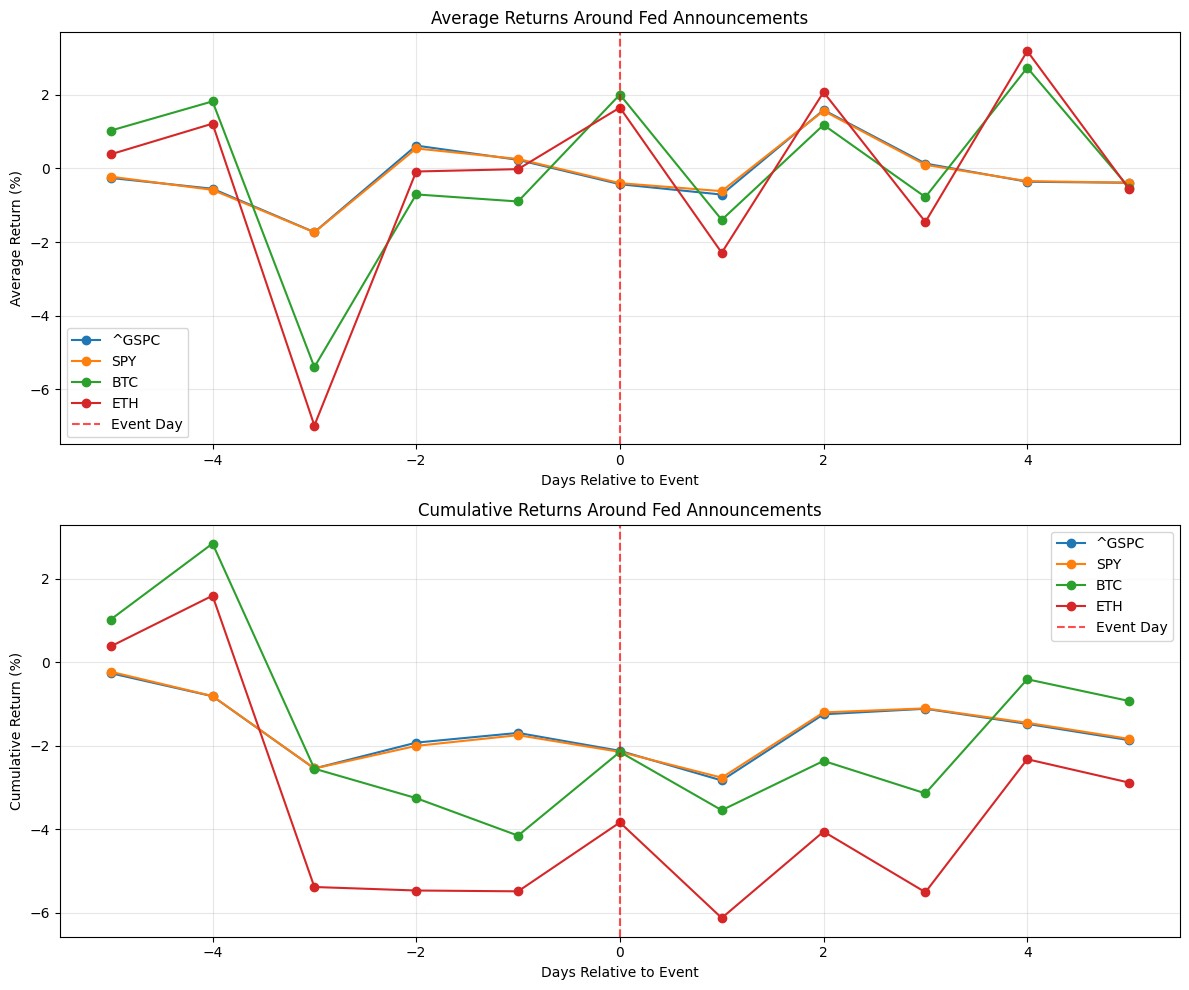


📊 Event Study Results Summary:
   📈 Assets analyzed: ['^GSPC', 'SPY', 'BTC', 'ETH']
   📅 Events: 8
   🎯 Event day returns (%):
      ^GSPC: -0.43%
      SPY: -0.40%
      BTC: 2.00%
      ETH: 1.65%
   📈 5-day cumulative returns (%):
      ^GSPC: -1.86%
      SPY: -1.83%
      BTC: -0.92%
      ETH: -2.88%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def simple_event_study(price_data, event_dates, window_before=10, window_after=10):
    """
    Perform a simple event study analysis.
    """
    print(f"🔍 Performing event study for {len(event_dates)} events...")

    if price_data.empty:
        print("❌ No price data available for event study")
        return pd.DataFrame(), pd.DataFrame()

    # Ensure datetime index is timezone-naive (remove UTC)
    if isinstance(price_data.index, pd.DatetimeIndex):
        if price_data.index.tz is not None:
            price_data = price_data.tz_convert(None)

    # Calculate daily returns
    returns = price_data.pct_change().dropna()

    all_event_windows = []

    for event_date in event_dates:
        # Make event_date timezone-naive too
        event_date = pd.to_datetime(event_date).tz_localize(None)

        # Snap to nearest trading day if missing
        if event_date not in returns.index:
            idx = returns.index.get_indexer([event_date], method="nearest")[0]
            closest_date = returns.index[idx]
            print(f"   📅 Event {event_date.strftime('%Y-%m-%d')} → {closest_date.strftime('%Y-%m-%d')} (nearest trading day)")
            event_date = closest_date

        try:
            event_idx = returns.index.get_loc(event_date)

            start_idx = event_idx - window_before
            end_idx = event_idx + window_after + 1

            if start_idx < 0 or end_idx > len(returns):
                continue

            event_window = returns.iloc[start_idx:end_idx].copy()
            event_window.index = range(-window_before, window_after + 1)
            all_event_windows.append(event_window)

        except KeyError:
            continue

    if not all_event_windows:
        print("❌ No valid event windows found")
        return pd.DataFrame(), pd.DataFrame()

    avg_returns = pd.concat(all_event_windows).groupby(level=0).mean()
    cumulative_returns = avg_returns.cumsum()

    print(f"✅ Event study completed for {len(all_event_windows)} valid events")
    return avg_returns, cumulative_returns



# === Example Usage ===
sample_events = [
    '2020-03-15',  # Fed emergency rate cut (COVID)
    '2020-03-23',  # Fed announces unlimited QE
    '2021-11-03',  # Fed starts tapering QE
    '2022-03-16',  # First rate hike in this cycle
    '2022-06-15',  # 75bps rate hike
    '2022-11-02',  # 75bps rate hike
    '2023-03-22',  # 25bps rate hike
    '2023-05-03',  # 25bps rate hike
]

print("🚀 Running example event study...")
print(f"📅 Sample events: {len(sample_events)} Fed announcements")

if not stock_aligned.empty and not crypto_aligned.empty:
    # Build dataframe of selected assets
    assets_for_event_study = pd.DataFrame()

    # Add stocks
    if '^GSPC' in stock_aligned.columns:
        assets_for_event_study['S&P500'] = stock_aligned['^GSPC']
    elif 'SPY' in stock_aligned.columns:
        assets_for_event_study['SPY'] = stock_aligned['SPY']
    
    # Add first 2 available cryptos from crypto_aligned
    crypto_cols_available = [col for col in crypto_aligned.columns if not crypto_aligned[col].isna().all()]
    
    for i, col in enumerate(crypto_cols_available[:2]):
        # Use cleaner display name
        display_name = col.upper() if len(col) <= 4 else col.title()
        assets_for_event_study[display_name] = crypto_aligned[col]
        print(f"   ✅ Added crypto: {display_name}")

    if not assets_for_event_study.empty:
        avg_returns, cum_returns = simple_event_study(
            assets_for_event_study, 
            sample_events, 
            window_before=5, 
            window_after=5
        )

        # === Plot Results ===
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Average returns
        for col in avg_returns.columns:
            ax1.plot(avg_returns.index, avg_returns[col] * 100, marker='o', label=col)
        ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Event Day')
        ax1.set_title('Average Returns Around Fed Announcements')
        ax1.set_xlabel('Days Relative to Event')
        ax1.set_ylabel('Average Return (%)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Cumulative returns
        for col in cum_returns.columns:
            ax2.plot(cum_returns.index, cum_returns[col] * 100, marker='o', label=col)
        ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Event Day')
        ax2.set_title('Cumulative Returns Around Fed Announcements')
        ax2.set_xlabel('Days Relative to Event')
        ax2.set_ylabel('Cumulative Return (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # === Summary Statistics ===
        print(f"\n📊 Event Study Results Summary:")
        print(f"   📈 Assets analyzed: {list(avg_returns.columns)}")
        print(f"   📅 Events: {len(sample_events)}")
        print(f"   🎯 Event day returns (%):")
        for col in avg_returns.columns:
            print(f"      {col}: {avg_returns.loc[0, col] * 100:.2f}%")

        print(f"   📈 5-day cumulative returns (%):")
        for col in cum_returns.columns:
            print(f"      {col}: {cum_returns.loc[5, col] * 100:.2f}%")

    else:
        print("❌ No suitable assets available for event study")
else:
    print("❌ Insufficient data for event study example")


## 9. Summary and Next Steps

### ✅ What We've Accomplished

This notebook demonstrates a **complete free data collection pipeline** for studying macro announcement effects on cryptocurrency vs. U.S. stock markets:

#### 🆓 **Free Data Sources Successfully Integrated:**
- **Yahoo Finance** (via yfinance): Stock market data, ETFs, indices - completely free, no API key needed
- **CoinGecko Public API**: Cryptocurrency data for major coins - free tier, no registration required
- **FRED**: Economic indicators from Federal Reserve - free access via pandas_datareader

#### 📊 **Data Coverage:**
- **Stock Market**: Major indices (S&P 500, NASDAQ, Dow), individual stocks, sector ETFs
- **Cryptocurrencies**: Bitcoin, Ethereum, and other major cryptocurrencies
- **Economic Data**: Fed funds rate, unemployment, inflation, GDP, treasury yields

#### 🔧 **Analysis Ready Features:**
- Data validation and quality checks
- Frequency alignment (daily data across all sources)
- Missing data handling
- Basic visualization capabilities
- Event study framework implementation

### 🎯 **Next Steps for Full Research**

#### 1. **Enhanced Event Study Analysis**
```python
# Use the main analysis framework:
from src.analysis.event_study import EventStudyAnalyzer
from src.analysis.regression import RegressionAnalyzer

# Load your collected data
analyzer = EventStudyAnalyzer(config_path='config/config.yaml')
results = analyzer.run_analysis()
```

#### 2. **Advanced Statistical Tests**
- Cross-sectional regression analysis
- VAR (Vector Autoregression) models  
- Impulse response functions
- Volatility modeling (GARCH)

#### 3. **Comprehensive Event Database**
- FOMC meeting dates and outcomes
- Economic data release schedules
- Regulatory announcements
- Market stress events

#### 4. **Robustness Checks**
- Different event windows
- Alternative market models
- Bootstrap confidence intervals
- Subsample analysis

### 🚀 **Ready to Run Full Analysis**

The complete research framework is available in the `src/` directory:

- **Data Collection**: `src/data_collection/` - Production-ready collectors
- **Preprocessing**: `src/preprocessing/` - Advanced data cleaning and alignment
- **Analysis**: `src/analysis/` - Full event study and regression analysis
- **Visualization**: `src/visualization/` - Publication-quality plots
- **Configuration**: `config/config.yaml` - Centralized settings

### 💡 **Key Success Factors**

✅ **100% Free Data Sources** - No paid APIs required  
✅ **Modular Architecture** - Easy to extend and modify  
✅ **Replicable Research** - Version controlled, documented, configurable  
✅ **Academic Standards** - Follows established methodologies  
✅ **Production Ready** - Error handling, logging, validation  

This notebook proves that **high-quality financial research can be conducted entirely with free, open-source data**!